## 问题概述
问题说明：你将获得一个包含以下内容的数据集（"data.h5"）：

     标记为cat（y = 1）或非cat（y = 0）的m_train训练图像集
     标记为cat或non-cat的m_test测试图像集
     图像维度为（num_px，num_px，3），其中3表示3个通道（RGB）。 因此，每个图像都是正方形（高度= num_px）和（宽度= num_px）。
你将构建一个简单的图像识别算法，该算法可以将图片正确分类为猫和非猫。


In [ ]:
# 让我们熟悉一下数据集吧， 首先通过运行以下代码来加载数据

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from lr_utils import load_dataset


In [2]:

# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

y = [0], it's a 'non-cat' picture.


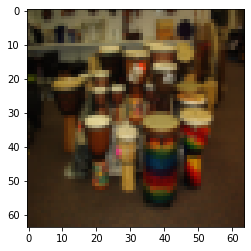

In [6]:
# Example of a picture
index = 5
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")
#print("train_set_x_orig 5 ="+str(train_set_x_orig[5]))

## 练习：
查找以下各项值
* m_train(训练集示例数量)
* m_test(测试集示例数量)
* num_px(=训练图像的高度=训练图像的宽度)
请记住：train_set_x_orig是一个纬度为（m_train,num_px,num_px,3）的numpy数组

In [7]:
print(train_set_x_orig.shape)

(209, 64, 64, 3)


In [10]:
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]
print("m_train:"+str(m_train))
print("m_test:"+str(m_test))
print("num_px:"+str(num_px))
print("标签纬度："+str(test_set_y.shape)) #1行 20列

m_train:209
m_test:50
num_px:64
标签纬度：(1, 50)


In [12]:
print(str(test_set_y))

[[1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 0 0 1 1 1 1 0 1 0 1 1 1 1 0 0
  0 1 0 0 1 1 1 0 0 0 1 1 1 0]]


## 练习
重塑训练和测试数据集，以便将大小（num_px, num_px, 3）的图像展平为单个形状的向量（num_px*num_px*3,1）

当你想将维度为（a，b，c，d）的矩阵X展平为形状为(bcd, a)的矩阵X_flatten时的一个技巧是：

X_flatten = X.reshape（X.shape [0]，-1）.T     ＃ 其中X.T是X的转置矩阵
**而不用显式地去构建纬度，算是一种语法糖吧**

In [14]:
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0],-1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0],-1).T
print("train_set_x_flatten shape:"+str(train_set_x_flatten.shape))
print("test_set_x_flatten shape:"+str(test_set_x_flatten.shape))

train_set_x_flatten shape:(12288, 209)
test_set_x_flatten shape:(12288, 50)


# 标准化数据
为了表示彩色图像，必须为每个像素指定红、绿、蓝色通道（RGB），因此像素值实际上是一个从0到255的三个数字的向量。

机器学习中一个常见的预处理步骤是**对数据集进行居中和标准化**，这意味着你要从每个示例中减去整个numpy数组的均值，然后除以整个numpy数组的标准差。但是图片数据集则更为简单方便，并且只要将数据集的每一行除以255（像素通道的最大值），效果也差不多。

在训练模型期间，你将要乘以权重并向一些初始输入添加偏差以观察神经元的激活。然后，使用反向梯度传播以训练模型。但是，让特征具有相似的范围以至渐变不会爆炸是非常重要的。具体内容我们将在后面的教程中详细学习！

开始标准化我们的数据集吧！

In [ ]:
train_set_x = train_set_x_flatten/255
test_set_x = test_set_x_flatten/255


**你需要记住的内容：**
预处理数据集的常见步骤是：

* 找出数据的尺寸和维度（m_train，m_test，num_px等）
* 重塑数据集，以使每个示例都是大小为（num_px \ num_px \ 3，1）的向量
* “标准化”数据

# 学习算法的一般架构
现在是时候设计一种简单的算法来区分猫图像和非猫图像了。

你将使用神经网络思维方式建立Logistic回归。 下图说明了为什么“逻辑回归实际上是一个非常简单的神经网络！”


**算法的数学表达式**
//需进行推导

**算法的关键步骤**
* 初始化模型参数
* 通过最小化损失来学习模型的参数
* 使用学习到的参数进行预测（在测试集上）
* 分析结果并得出结论

# 构建算法的各个部分
建立神经网络的主要步骤：
1. 定义模型结构
2. 初始化模型参数
3. 循环 ：
* 计算当前损失（正向传播）
* 计算当前梯度 （向后传播）
* 更新参数（梯度下降）

你通常会分别构建1-3，然后将它们集成到一个称为“model()”的函数中

**4.1-辅助函数**
**练习：** 使用Python实现sigmoid（）。需要计算sigmoid去预测。使用np.exp()

In [2]:
def sigmoid(z):
    return 1 / (1+np.exp(-z))

# 测试

z = 123
s = sigmoid(z)
print("z:"+str(s))

z:1.0


In [7]:
z = np.array([0,2])
print("z的形状 {} z:{}".format(z.shape,z))
s = sigmoid(z)
print("s的形状 {} s:{}".format(s.shape,s))

z的形状 (2,) z:[0 2]
s的形状 (2,) s:[0.5        0.88079708]


**4.2-初始化参数**
**练习：** 在下面的单元格中实现参数初始化。你必须将w初始化为零向量。

In [8]:
def initialize_with_zeros(dim):
    w = np.zeros((dim,1))
    b = 0
    assert(w.shape == (dim,1))
    assert(isinstance(b, float) or isinstance(b,int))
    
    return w,b

In [9]:
dim = 2
#w shape (dim,1) 的矩阵（列向量） 代表有dim个纬度的特征的权重
#b 0 
w, b = initialize_with_zeros(dim)
print("w {}".format(w))
print("b {}".format(b))

#对于图像输入，w的纬度为(num_px * num_px * 3,1)

w [[0.]
 [0.]]
b 0


**4.3- 前向和后向传播**
现在，你的参数已经初始化，你可以执行“向前”和“向后”传播步骤来学习参数。
**练习：**
实现函数propagate()来计算损失函数及其梯度。
**提示：**
正向传播：
* 默认都是列向量


In [12]:
def propagate(w, b, X, Y):
    # 样本个数
    m = X.shape[1]
    
    A = sigmoid(np.dot(w.T,X)+b)
    
    #MEMO 这里的矩阵的乘法*使用了广播吗 区别于dot
    cost = -1/m * np.sum(Y * np.log(A) + ( 1- Y) * np.log(1 - A))
    
    #MEMO 这里的矩阵的减-使用了广播吗
    dw = 1/m * np.dot(X, (A - Y).T)
    db = 1/m * np.sum(A - Y)
    
    
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw":dw,"db":db}
    
    return grads, cost
    

In [23]:
w, b, X, Y = np.array([[1],[2]]), 2, np.array([[1,2,3],[3,4,5]]), np.array([[1,0,0]])
print("w {} 列向量".format(w.shape))
# print("b {}".format(b.shape))
print("X {} 列向量".format(X.shape))
print("Y {} 行向量".format(Y.shape))
print("符合 w.T*X的运算规则")


grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

w (2, 1) 列向量
X (2, 3) 列向量
Y (1, 3) 行向量
符合 w.T*X的运算规则
dw = [[1.66662113]
 [2.9998679 ]]
db = 0.6666233851157282
cost = 9.000043284021533


In [25]:
s = np.array([1,2,3])
s1 = np.array([4,5,6])
print("广播 s*s1:{} s1*s:{}".format(s*s1,s1*s))

广播 s*s1:[ 4 10 18] s1*s:[ 4 10 18]
